Epoch 1/4000
10/10 [==============================] - 3s 29ms/step - loss: 1.5865 - accuracy: 0.2550
Epoch 2/4000
10/10 [==============================] - 0s 31ms/step - loss: 1.3299 - accuracy: 0.5795
Epoch 3/4000
10/10 [==============================] - 0s 27ms/step - loss: 1.2322 - accuracy: 0.5795
Epoch 4/4000
10/10 [==============================] - 0s 26ms/step - loss: 1.1971 - accuracy: 0.5795
Epoch 5/4000
10/10 [==============================] - 0s 26ms/step - loss: 1.1892 - accuracy: 0.5795
Epoch 6/4000
10/10 [==============================] - 0s 28ms/step - loss: 1.1811 - accuracy: 0.5795
Epoch 7/4000
10/10 [==============================] - 0s 28ms/step - loss: 1.1787 - accuracy: 0.5795
Epoch 8/4000
10/10 [==============================] - 0s 28ms/step - loss: 1.1763 - accuracy: 0.5795
Epoch 9/4000
10/10 [==============================] - 0s 30ms/step - loss: 1.1726 - accuracy: 0.5795
Epoch 10/4000
10/10 [==============================] - 0s 27ms/step - loss: 1.1685 - accura

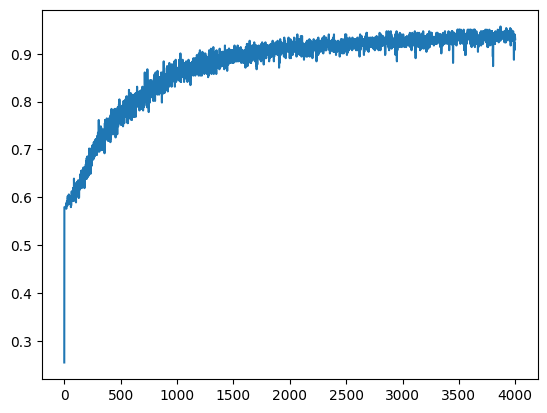

Test loss: 4.255940914154053
Test accuracy: 0.4868420958518982


<AxesSubplot: >

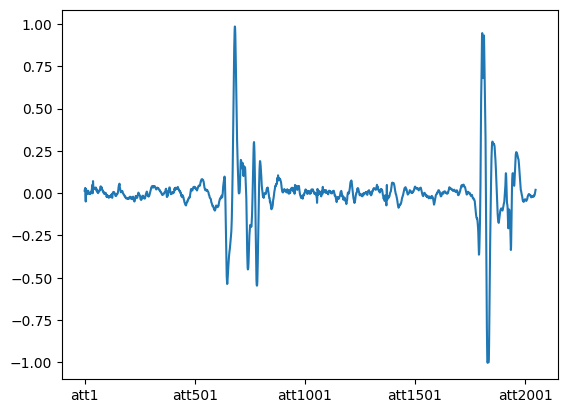

In [1]:
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.models import Model
import tensorflow as tf


from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np

#this base model is one branch of the main model

#it takes a time series as an input, performs 1-D convolution, and returns it as an output ready for concatenation
def get_base_model(input_len, fsize):
    
    #the input is a time series of length n and width 1
    input_seq = Input(shape=(input_len, 1))
    
    #choose the number of convolution filters
    nb_filters = 10

    #1-D convolution and global max-pooling
    convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)

    #dense layer with dropout regularization
    compressed = Dense(50, activation="tanh")(processed)
    compressed = Dropout(0.3)(compressed)
    model = Model(inputs=input_seq, outputs=compressed)
    return model

#this is the main model

#it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
def main_model(inputs_lens = [763, 1526, 3052], fsizes = [8,16,24]):
    
    #the inputs to the branches are the original time series, and its down-sampled versions
    input_smallseq = Input(shape=(inputs_lens[0], 1))
    input_medseq = Input(shape=(inputs_lens[1] , 1))
    input_origseq = Input(shape=(inputs_lens[2], 1))

    #the more down-sampled the time series, the shorter the corresponding filter
    base_net_small = get_base_model(inputs_lens[0], fsizes[0])
    base_net_med = get_base_model(inputs_lens[1], fsizes[1])
    base_net_original = get_base_model(inputs_lens[2], fsizes[2])
    embedding_small = base_net_small(input_smallseq)
    embedding_med = base_net_med(input_medseq)
    embedding_original = base_net_original(input_origseq)
    
    #concatenate all the outputs
    merged = Concatenate()([embedding_small, embedding_med, embedding_original])
    layer = Dense(50, activation='sigmoid')(merged)
    out = Dense(5, activation='softmax')(layer)
    model = Model(inputs=[input_smallseq, input_medseq, input_origseq], outputs=out)
    return model

def load_data(filename_arff):
    dataset = arff.loadarff(filename_arff)
    data = dataset[0]
    df = pd.DataFrame(data)
    input_data_df = df.iloc[:, 0:3052]
    
    #creating instance of one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')
    
    #perform one-hot encoding on 'team' column 
    labels_df = pd.DataFrame(encoder.fit_transform(df[['target']]).toarray())    
    labels_df.columns = ['Artifact','ExtraHLS','ExtraStole','Murmur','Normal']
    return input_data_df, labels_df

m = main_model()
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

(X_train, y_train) = load_data('AbnormalHeartbeat_TRAIN.arff')
(X_test, y_test) = load_data('AbnormalHeartbeat_TEST.arff')


X_train_downsampled2 = X_train.iloc[:,::2]
X_train_downsampled4 = X_train.iloc[:,::4]

history = m.fit([X_train_downsampled4, X_train_downsampled2, X_train], y_train, epochs=4000)

# plot metrics
plt.plot(history.history['accuracy'])
plt.show()

X_test_downsampled2 = X_test.iloc[:,::2]
X_test_downsampled4 = X_test.iloc[:,::4]
score = m.evaluate([X_test_downsampled4, X_test_downsampled2, X_test], y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

df = X_test.T

df.iloc[0:2048,300].plot()


In [ ]:
from scipy.io import arff
import pandas as pd

dataset = arff.loadarff('AbnormalHeartbeat_TEST.arff')
data = dataset[0]
df = pd.DataFrame(data)

df.info()
df.head()

In [ ]:
import arff
import numpy as np

dataset = arff.load(open('AbnormalHeartbeat_TRAIN.arff', 'rt'))
data = np.array(dataset['data'])

input_data_str = data[:, 0:3052]
input_data = input_data_str.astype(np.float32)
labels = data[:,3053]

In [ ]:
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

dataset = arff.loadarff('AbnormalHeartbeat_TEST.arff')
data = dataset[0]

df = pd.DataFrame(data)

input_data_df = df.iloc[:, 0:3052]

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
labels_df = pd.DataFrame(encoder.fit_transform(df[['target']]).toarray())

print("Done")



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

p = np.linspace(0,40,100)
plt.plot(p,np.sin(17*p))
plt.show()